In [2]:
# General Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Astronomy Specific Imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

# Image Analysis Specific Imports
from skimage.measure import perimeter, euler_number

import porespy as ps
ps.visualization.set_mpl_style()

def remove_region(data, wcs, longitude_min, longitude_max, latitude_min, latitude_max):
    
    min_coord_remove = SkyCoord(longitude_min, latitude_min, frame='galactic', unit=u.deg)
    max_coord_remove = SkyCoord(longitude_max, latitude_max, frame='galactic', unit=u.deg)

    min_pixel_remove = wcs[:][:][0].world_to_pixel(min_coord_remove)
    max_pixel_remove = wcs[:][:][0].world_to_pixel(max_coord_remove)

    # Create a mask based on these galactic coordinates
    remove_mask = np.zeros(data.shape, dtype=bool)

    # Set True in the mask for the specified region based on pixel indices
    y_min, x_min = int(np.floor(min_pixel_remove[1])), int(np.floor(min_pixel_remove[0]))
    y_max, x_max = int(np.ceil(max_pixel_remove[1])), int(np.ceil(max_pixel_remove[0]))

    # Apply the mask to the region within the pixel boundaries
    remove_mask[y_min:y_max, x_max:x_min] = True
    
    # Apply the mask to the original data to set the region to NaN or another value
    data[remove_mask] = np.nan  # Replace with np.nan to exclude the data

    return data

def derive_density_maps():
    # Get the current working directory
    curr_folder = os.getcwd()

    # Find the index of 'notebooks' in the current path
    notebooks_index = curr_folder.rfind('notebooks')

    # Check if 'notebooks' is found in the path
    if notebooks_index != -1:
        # Set the directory to the parent of 'notebooks'
        src_path = os.path.dirname(curr_folder[:notebooks_index])
        os.chdir(src_path)  # Change the current working directory to the source path
        sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports

    # Construct the path to the FITS file
    planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")

    hdu_herschel_fits = fits.open(planck_herschel_fits_file)[0]
    
    # Constructt WCS and image data
    wcs = WCS(hdu_herschel_fits.header)

    image_data = hdu_herschel_fits.data[0]

    # Replace NaNs and Infs with some valid value, e.g., zero or the median
    tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

    # Step 1: Define constants
    # TO-DO: differentiate between Orion A and B 

    # Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
    # Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

    # Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    # Making it smaller cause of computation time
    # l_min_A, l_max_A = 210, 212
    # b_min_A, b_max_A = -21, -20

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    gamma_orion_A = 2640  # mag
    delta_orion_A = 0.012  # mag, Offset for Orion A

    A_k = gamma_orion_A * tau + delta_orion_A

    A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    gamma_orion_B = 3460  # mag
    delta_orion_B = -0.001  # mag, Offset for Orion B

    A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

    # A_k to A_V
    A_V = A_k/0.112

    # N(H2)
    N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

    # Define regions to remove as a list of dictionaries
    regions_to_remove = [
        # Orion A regions
        {"longitude_min": 208, "longitude_max": 211, "latitude_min": -17.9, "latitude_max": -16.9},
        {"longitude_min": 214.5, "longitude_max": 216.5, "latitude_min": -18, "latitude_max": -17},
        {"longitude_min": 206, "longitude_max": 206.5, "latitude_min": -19.5, "latitude_max": -19},

        # Orion B regions
        {"longitude_min": 208, "longitude_max": 210, "latitude_min": -15, "latitude_max": -12},
        {"longitude_min": 209, "longitude_max": 210, "latitude_min": -16.4, "latitude_max": -15.5},
        {"longitude_min": 203, "longitude_max": 205, "latitude_min": -12.3, "latitude_max": -11.5},
        {"longitude_min": 204.5, "longitude_max": 205.5, "latitude_min": -12.2, "latitude_max": -11.5},
        {"longitude_min": 205.8, "longitude_max": 207, "latitude_min": -13.5, "latitude_max": -12.5},
    ]

    # Loop through each region and remove it from N_H2
    for region in regions_to_remove:
        N_H2 = remove_region(
            N_H2,
            wcs,
            region["longitude_min"],
            region["longitude_max"],
            region["latitude_min"],
            region["latitude_max"]
        )

    
    N_H2_OA = N_H2[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]
    N_H2_OB = N_H2[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]

    N_H2 = np.nan_to_num(N_H2, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OA = np.nan_to_num(N_H2_OA, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OB = np.nan_to_num(N_H2_OB, nan=0.0, posinf=0.0, neginf=0.0)
    
    return N_H2, N_H2_OA, N_H2_OB, wcs

N_H2, N_H2_OA, N_H2_OB, wcs = derive_density_maps()

[11:41:43] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=610285;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=58821;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

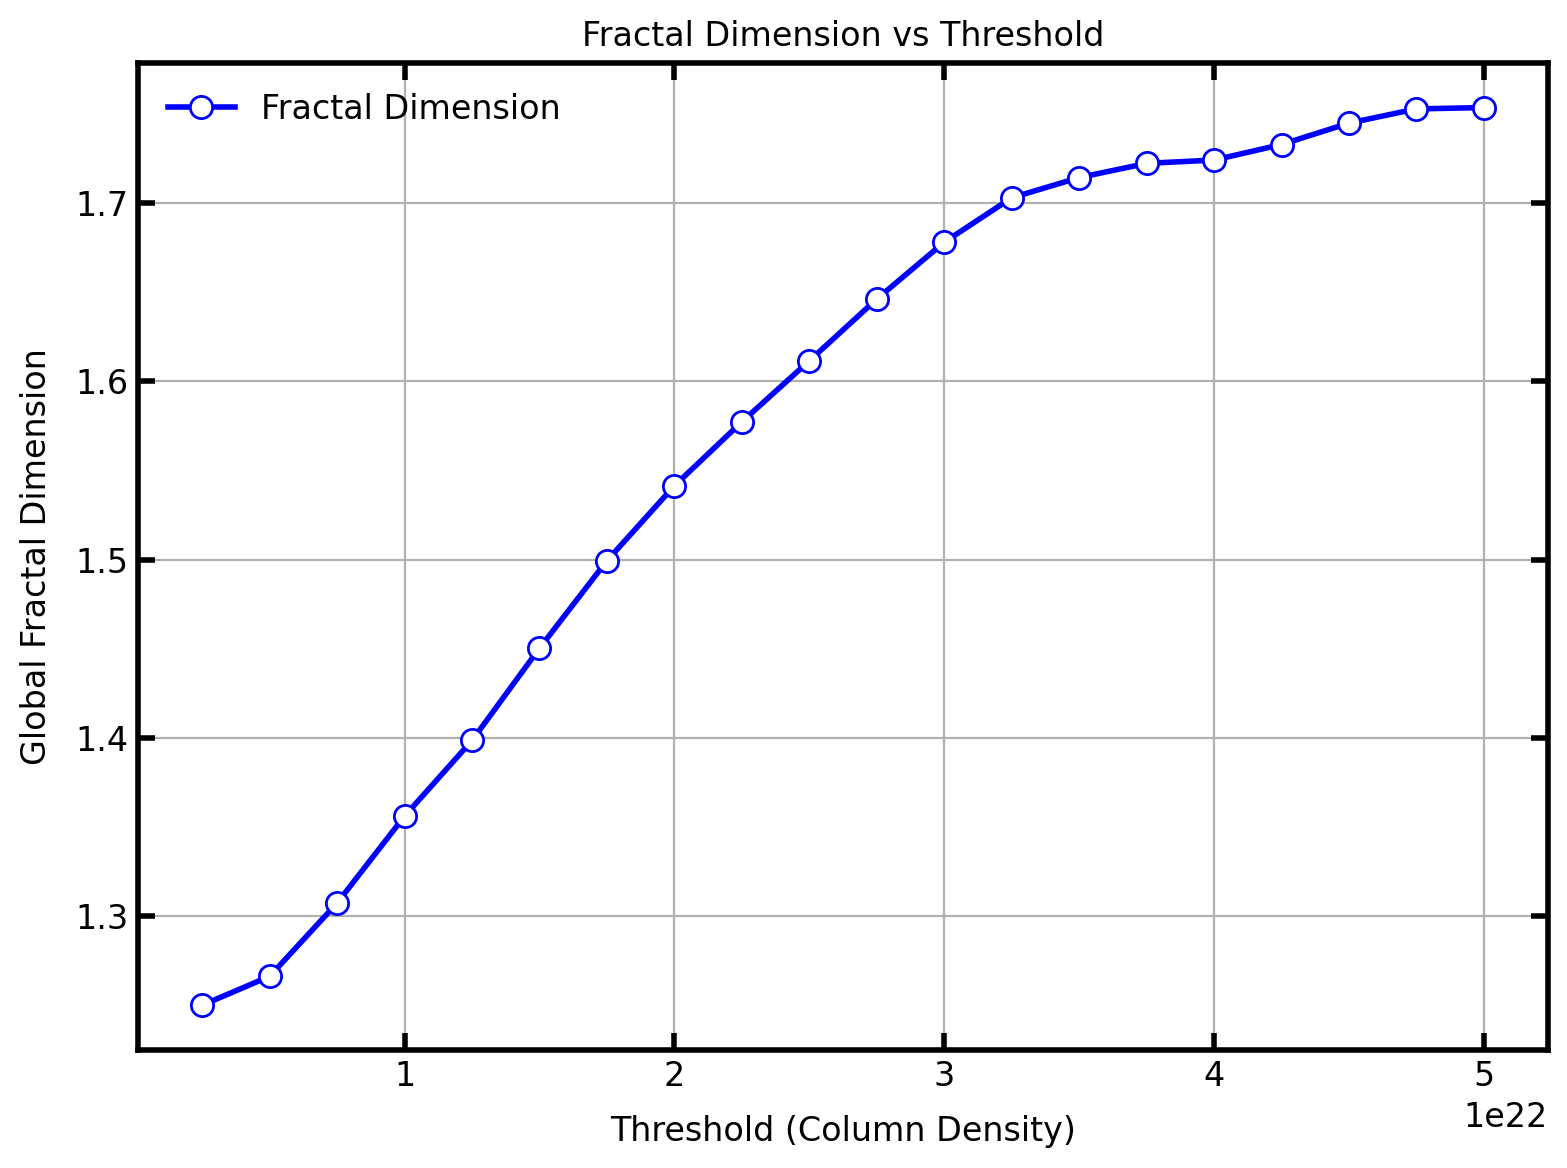

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift
from scipy.optimize import curve_fit

def get_fractal_dimension_2d_fft(image, nRho=40, nPhi=15):
    """
    Computes the fractal dimension of a 2D image using FFT-based PSD analysis.
    
    Parameters:
    - image (2D array): Input 2D image (interpreted as a surface map of grayscale heights).
    - nRho (int): Number of radial distance bins in frequency space.
    - nPhi (int): Number of angular direction bins in frequency space.
    
    Returns:
    - fDGlobal (float): Global median fractal dimension.
    - fDAtAngle (1D array): Fractal dimension at different angular sectors.
    - phi1D (1D array): Angular positions (in degrees) of the sectors.
    """
    # Normalize the image
    image = image.astype(np.float64)
    image = (image - np.mean(image)) / np.std(image)
    
    # Get image dimensions and center coordinates
    ny, nx = image.shape
    x0, y0 = nx // 2, ny // 2  # center of the image
    
    # Compute the 2D FFT and log-PSD
    fft_image = fft2(image)
    fft_image = fftshift(fft_image)  # Shift zero frequency to the center
    psd = np.log(np.abs(fft_image)**2 + 1e-6)  # Add small value to avoid log(0)
    
    # Create frequency grids
    x1D = np.arange(nx) - x0
    y1D = np.arange(ny) - y0
    X2D, Y2D = np.meshgrid(x1D, y1D)
    rho2D = np.log(np.sqrt(X2D**2 + Y2D**2) + 1e-6)  # Logarithmic radial distances
    phi2D = np.degrees(np.arctan2(Y2D, X2D)) % 360  # Angular directions (0 to 360 degrees)
    
    # Define radial and angular bins
    rho_max = np.log(min(nx, ny) / 2)
    phi_bounds = np.linspace(0, 360, nPhi + 1)
    rho_bounds = np.linspace(0.03 * rho_max, rho_max, nRho + 1)
    phi1D = phi_bounds[:-1] + np.diff(phi_bounds) / 2  # Bin centers for angles
    rho1D = rho_bounds[:-1] + np.diff(rho_bounds) / 2  # Bin centers for radii
    
    # Compute average PSD in each (rho, phi) sector
    sector_psd = np.zeros((nRho, nPhi))
    for iPhi in range(nPhi):
        for iRho in range(nRho):
            mask = (
                (phi_bounds[iPhi] <= phi2D) & (phi2D < phi_bounds[iPhi + 1]) &
                (rho_bounds[iRho] <= rho2D) & (rho2D < rho_bounds[iRho + 1])
            )
            sector_psd[iRho, iPhi] = np.mean(psd[mask]) if np.any(mask) else np.nan
    
    # Compute slope for each angular sector
    slope_at_angle = np.zeros(nPhi)
    for iPhi in range(nPhi):
        valid = ~np.isnan(sector_psd[:, iPhi])
        if np.any(valid):
            rho_valid = rho1D[valid]
            psd_valid = sector_psd[valid, iPhi]
            P = np.polyfit(rho_valid, psd_valid, 1)  # Linear fit
            slope_at_angle[iPhi] = P[0]
    
    # Compute fractal dimensions
    E = 1.0  # Euclidian distance of 2.0 (might as well be one, example coastlines (P. 35 of Fractals in Nature))
    fDGlobal = E + (3.0 - np.abs(np.median(slope_at_angle))) / 2.0
    # fDGlobal = np.clip(fDGlobal, 2.0, 3.0)  # Ensure within surface fractal bounds
    # fDAtAngle = E + (3.0 - np.abs(slope_at_angle)) / 2.0
    
    return fDGlobal, phi1D


threshold_min = 2.5e21
threshold_max = 5e22

# Define thresholds for binarization
thresholds = np.linspace(threshold_min, threshold_max, 20)

# Calculate fractal dimensions for each threshold
fDGlobal_values = []
for threshold in thresholds:
    masked_image = np.copy(N_H2_OA)
    masked_image[masked_image < threshold] = 0  # Mask values below threshold (not binary map here!)
    fDGlobal, _= get_fractal_dimension_2d_fft(masked_image)
    fDGlobal_values.append(fDGlobal)

# Plot fractal dimension vs. threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fDGlobal_values, marker='o', color='b', label='Fractal Dimension')
plt.xlabel('Threshold (Column Density)')
plt.ylabel('Global Fractal Dimension')
plt.title('Fractal Dimension vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
print(np.mean(fDGlobal_values))

1.6492780119867518


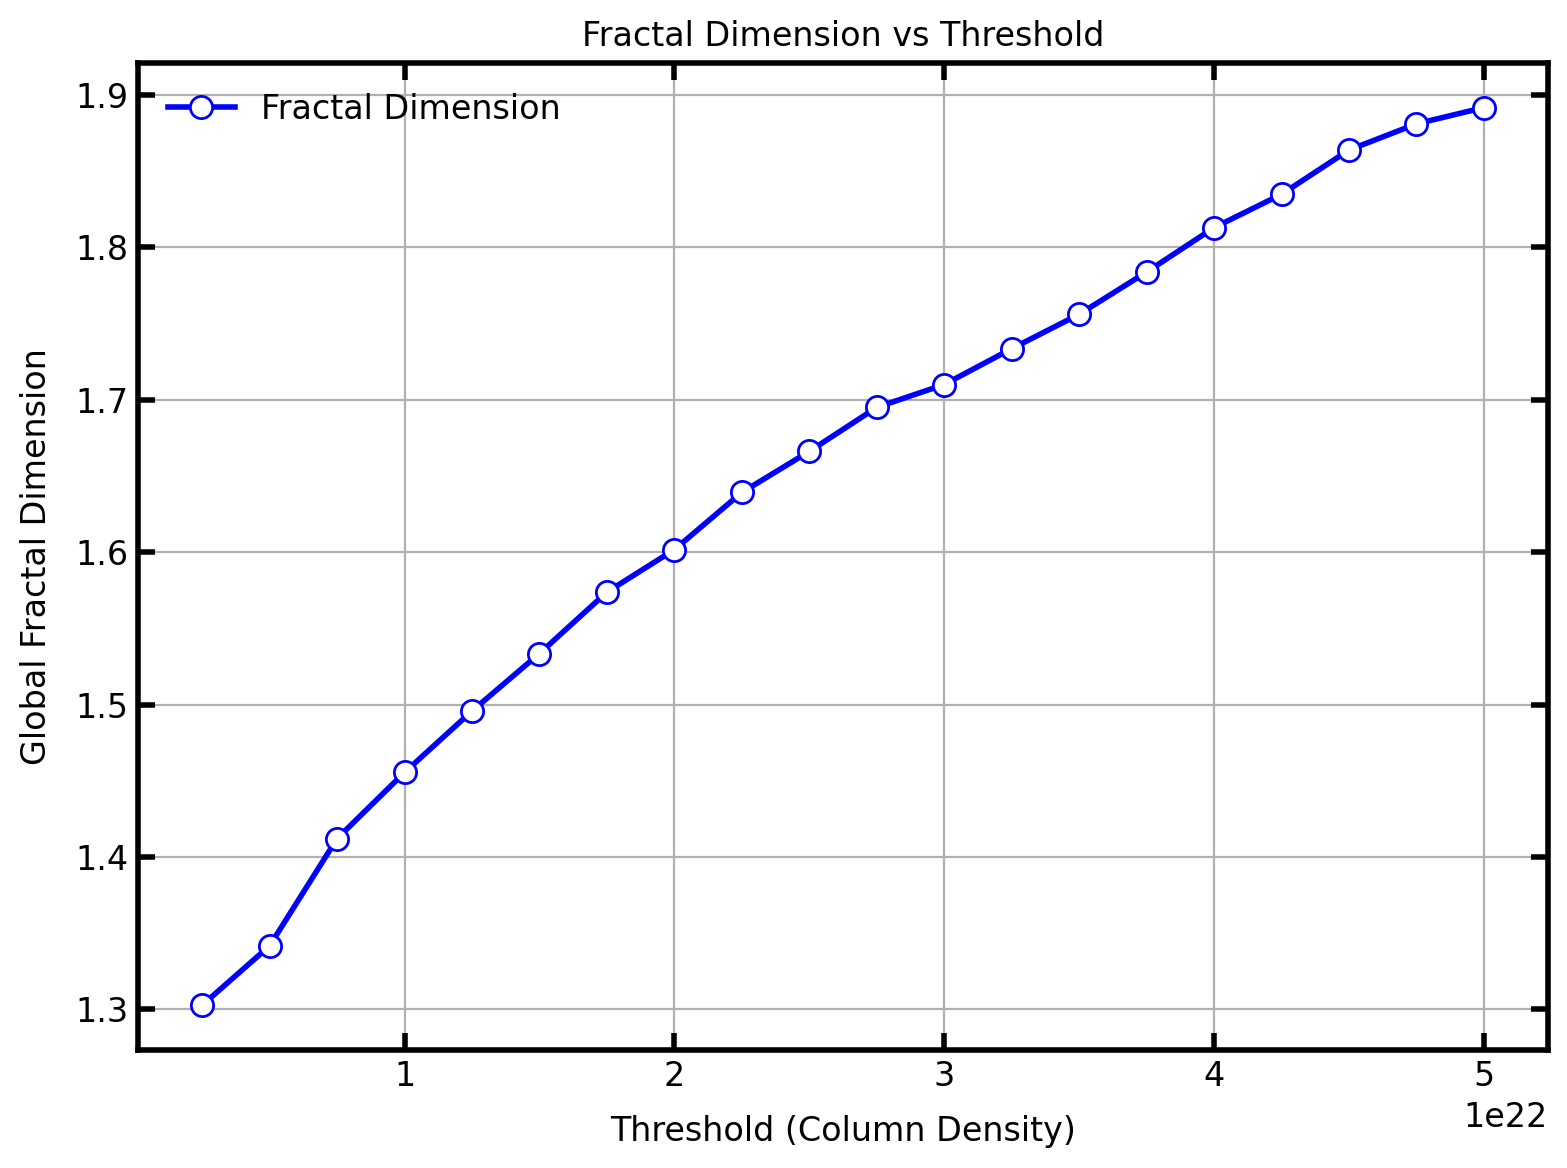

In [8]:
# Calculate fractal dimensions for each threshold
fDGlobal_values = []
for threshold in thresholds:
    masked_image = np.copy(N_H2_OB)
    masked_image[masked_image < threshold] = 0  # Mask values below threshold (not binary map here!)
    fDGlobal, _= get_fractal_dimension_2d_fft(masked_image)
    fDGlobal_values.append(fDGlobal)

# Plot fractal dimension vs. threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fDGlobal_values, marker='o', color='b', label='Fractal Dimension')
plt.xlabel('Threshold (Column Density)')
plt.ylabel('Global Fractal Dimension')
plt.title('Fractal Dimension vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
print(np.average(fDGlobal_values))

1.6492780119867518
